### <mark>Setup paths</mark>

In [1]:
# Add folder containing scripts to the path
import sys
sys.path.append('../') ## Change accordingly

# Command to execute LTSpice launch
LTSPICE_INSTANCE = "../../ltspice.sh" ## Change accordingly

In [2]:
# Store relative path from ltspice docker to current directory
import os
from pathlib import Path

ltspice_absolute = os.path.realpath(LTSPICE_INSTANCE)
ltspice_dir = os.path.dirname(ltspice_absolute)
notebook_dir = os.getcwd()

CURRENT_FOLDER = Path(notebook_dir).relative_to(ltspice_dir)
print("CURRENT_FOLDER:", CURRENT_FOLDER)

# Reload libraries automatically if is being changed on the fly
%load_ext autoreload
%autoreload 2

CURRENT_FOLDER: files/example


### <mark>Runtime parameters</mark>


In [3]:
CBA_PARAMETERS = {
    'states':    [1000, 200], # Order from HRS to LRS
    'wordline':  4,
    'bitline':   4,
    'bias_voltage': 0.5,
}
CIRCUIT_PARAMETERS = {
    'cell':      'cell_subcircuit_4x4',
    'crossbar':  'crossbar_subcircuit_4x4',
    'wrapper':   'wrapper_subcircuit_4x4',
}
SIM_PARAMETERS = {
    'exe':       LTSPICE_INSTANCE,
    'dir':       CURRENT_FOLDER,
}

### <mark>Generate until netlist</mark>


In [4]:
import generator as gen
import simulator as sim

gen.generate_cell(resistance_states=CBA_PARAMETERS['states'],
                  cell_subcircuit=CIRCUIT_PARAMETERS['cell'])
gen.generate_cba(wordline=CBA_PARAMETERS['wordline'],
                 bitline=CBA_PARAMETERS['bitline'],
                 filename=CIRCUIT_PARAMETERS['crossbar'],
                 cell_subcircuit=CIRCUIT_PARAMETERS['cell'],
                 wrapper=CIRCUIT_PARAMETERS['wrapper'])
sim.set_ltspice(exe=SIM_PARAMETERS['exe'], dir=SIM_PARAMETERS['dir'])
sim.convert_ltspice_sch_to_netlist(filename=CIRCUIT_PARAMETERS['wrapper'])

### <mark>Use the crossbar array</mark>


In [5]:
import numpy as np
from CrossbarArray import CbaRuntime

conductance = np.array([[1,0,0,0],
                        [1,1,0,0],
                        [1,1,-1,0], 
                        [1,1,-1,-1],])

cba_rt = CbaRuntime(CBA_PARAMETERS, SIM_PARAMETERS, CIRCUIT_PARAMETERS)
cba_rt.program_memory(conductance)

In [6]:
word = np.array([0.3, 0.2, 0.1, 0.2])
bit = np.array([0, 0, 0, 0])
cba_rt.set_wordline(word)
cba_rt.set_bitline(bit)

In [7]:
result1 = cba_rt.cba1.read_bit_current()
result2 = cba_rt.cba2.read_bit_current()
result = cba_rt.read_bitline()
print('CBA1:', result1)
print('CBA2:', result2)
print('CBA:', result)
print('Verify:', np.matmul(word, conductance))

> Simulation done
> Simulation done
CBA1: [0.004  0.0028 0.0008 0.0008]
CBA2: [-0.0008 -0.0008 -0.002  -0.0016]
CBA: [ 0.0032  0.002  -0.0012 -0.0008]
Verify: [ 0.8  0.5 -0.3 -0.2]


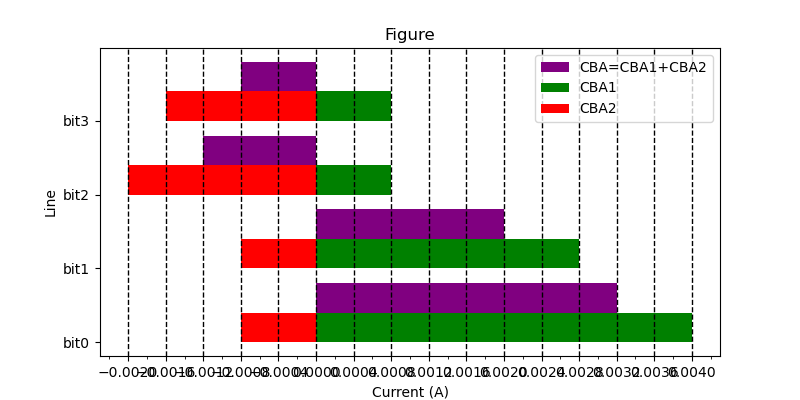

In [8]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

plt.figure(figsize=(8,4))

y = result
x = list(map(lambda a: f"bit{a}", range(len(y))))
plt.barh(x, y, label="CBA=CBA1+CBA2", height=0.4*2, align='edge', color='purple')

y = result1
plt.barh(x, y, label="CBA1", height=0.4, align='edge', color='green')

y = result2
plt.barh(x, y, label="CBA2", height=0.4, align='edge', color='red')

plt.title('Figure')
plt.xlabel('Current (A)')
plt.ylabel('Line')
plt.legend()

interval = 0.1 * (1/CBA_PARAMETERS['states'][-1] - 1/CBA_PARAMETERS['states'][0])
plt.gca().xaxis.set_major_locator(MultipleLocator(interval))
plt.gca().xaxis.set_minor_locator(AutoMinorLocator(2))
plt.grid(which='major', axis='x', color='black', linestyle ='--', linewidth = 1)

plt.ion()
plt.show()

### <mark>Cleanup</mark>

In [9]:
!rm *_tmp*
!rm *.log
!rm *.net*

rm: cannot remove '*.log': No such file or directory
